## Calorimeter GAN test
### Author: stephen.menary@manchester.ac.uk

---

### Step 1)  Grab a dataset of rings labelled by momentum

---

In [1]:
#  Create simulated dataset of rings and showers
#  -  datapoints are labelled by momentum

import Tools.shower_test_tools as tools

import numpy as np

num_pixels      = 21
num_simulations = 2000

TRAIN_X, TRAIN_Y, VAL_X, VAL_Y, TEST_X, TEST_Y = tools.get_rings_with_coordinates(
    do_x=False, 
    do_y=False, 
    do_p=True, 
    num_pixels=num_pixels, 
    num_simulations=num_simulations,
    tag="shower_tests_5")

print(f"   DATASET with size {len(TRAIN_X)}")

Generating rings... 100%
2000 rings saved to file
   DATASET with size 1000


---

### Step 2)  Plot some examples of our images

---

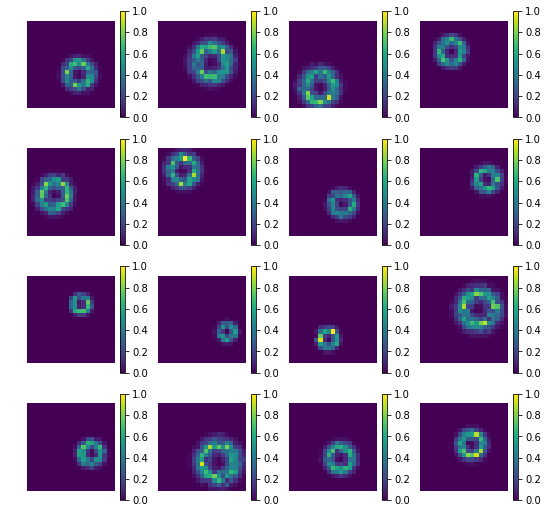

In [2]:
#  Plot some examples of datapoints
#

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,9))
for idx, (im, label) in enumerate(zip(TRAIN_X[:16], TRAIN_Y[:16])) :
    plt.subplot(4, 4, 1+idx)
    plt.imshow(im[:,:,0], vmin=0., vmax=1.)
    plt.colorbar()
    plt.axis('off')
plt.show()


---

### Step 3)  Create CNN discriminator, MLP generator and GAN

---

In [7]:
#  Create networks
#

from keras.layers import Dense, Flatten, Conv2D, Input, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from tensorflow import reshape


n_input_size = 81

discriminator = None
generator     = None


class Discriminator (Sequential) :
    def __init__ (self) :
        super(Discriminator, self).__init__(name="Discriminator")
        self.add(Conv2D(12, kernel_size=(3,3), activation="relu", input_shape=(num_pixels, num_pixels, 1)))
        self.add(Conv2D(10, kernel_size=(3,3), activation="relu"))
        self.add(Conv2D(8, kernel_size=(2,2), activation="relu"))
        self.add(Flatten())
        self.add(Dense(1024, activation="relu"))
        self.add(Dense(1   , activation="sigmoid"))
        self.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

def generator_loss (gen_out, y_pred):
    global discriminator
    return discriminator.evaluate(gen_out, y_pred)[0]

discriminator = Discriminator()

def create_generator_network () :
    model = Sequential(name="Generator")
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(num_pixels*num_pixels, activation="sigmoid"))
    model.add(Reshape(target_shape=(num_pixels, num_pixels, 1)))
    model.compile(optimizer="adam", loss=generator_loss, metrics=["accuracy"])
    return model

generator = create_generator_network()

discriminator.summary()
generator    .summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 19, 19, 12)        120       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 17, 10)        1090      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 8)         328       
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1025      
Total params: 2,100,739
Trainable params: 2,100,739
Non-trainable params: 0
___________________________________________

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 

---

### Step 4)  Train the network

---

In [ ]:
#  Fit the training data
#  - using early stopping, and storing best solution
#

import sys

from keras.callbacks import EarlyStopping
import scipy.stats as stats


def plot_epoch (e, noise, generated_image) :
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    plt.imshow(noise[0,:].reshape(int(np.sqrt(n_input_size)), int(np.sqrt(n_input_size))))
    plt.title(f"Input noise (epoch {e})")
    plt.colorbar()
    ax = fig.add_subplot(122)
    plt.imshow(generated_image[:,:,0], vmin=0., vmax=1.)
    plt.title(f"Generated image (epoch {e})")
    plt.colorbar()
    plt.show()


def training(gan, epochs=1, batch_size=128):
    for e in range(epochs):
        noise            = np.random.normal(0, 1, size=(batch_size, n_input_size))
        generated_images = generator.predict(noise)
        image_batch      = TRAIN_X[np.random.randint(low=0, high=TRAIN_X.shape[0], size=batch_size)]
            
        X      = np.concatenate([image_batch, generated_images])
        y_real = np.array([1 for i in range(batch_size)])
        y_fake = np.array([0 for i in range(batch_size)])
        y_true = np.concatenate([y_real, y_fake])
            
        if e % 10 == 0 :
            print(f"Epoch {e}: Discriminator accuracy is {100.*discriminator.evaluate(X, y_true, verbose=0)[1]:.0f}%")
            print(f"Epoch {e}: GAN accuracy is {100.*discriminator.evaluate(generated_images, y_real, verbose=0)[1]:.0f}%")
            plot_epoch(e, noise, generated_images[0])
            
        #Pre train discriminator on  fake and real data  before starting the gan.
        discriminator.trainable=True
        dis_loss, dis_acc = discriminator.train_on_batch(X, y_true)
        
        '''disc_idx = 0
        while (disc_idx < 50) and (dis_acc < 0.6) :
            if disc_idx % 10 == 0 :
                sys.stdout.write("\r"+f"Epoch {e}: improving Discriminator (attempt {disc_idx}) with accuracy of {100.*dis_acc:.0f}%".ljust(80))
                sys.stdout.flush()
            dis_loss, dis_acc = discriminator.train_on_batch(X, y_true)
            disc_idx = disc_idx + 1
        if disc_idx > 49 and gen_acc < 1e-5 :
            print("\n-- Replacing discriminator --")
            replace_discriminator()'''
            
        # During the training of gan, the weights of discriminator should be fixed. 
        discriminator.trainable=False
        gen_loss, gen_acc = gan.train_on_batch(noise, y_real)
        
        gan_idx = 0
        while (gan_idx < 50) and (gen_acc < 0.6) :
            if gan_idx % 10 == 0 :
                sys.stdout.write("\r"+f"Epoch {e}: improving Generator (attempt {gan_idx}) with accuracy of {100.*gen_acc:.0f}%".ljust(80))
                sys.stdout.flush()
            gen_loss, gen_acc = gan.train_on_batch(noise, y_real)
            gan_idx = gan_idx + 1
        if gan_idx > 0 :
            sys.stdout.write("\n")
            sys.stdout.flush()
        if gan_idx > 49 and gen_acc < 1e-5 :
            print("\n-- Replacing generator --")
            gan = replace_generator()
            
            
training(gan, 4000, 300)